# Présentation du dataset
Ce dataset provient de l'Open Access Series of Imaging Studies (OASIS), un projet visant à mettre à disposition gratuitement des ensembles de données IRM du cerveau à la communauté scientifique.

Le fichier csv `oasis_long` contient des données longitudinales organisées comme suit: 
- 150 patients adultes agés entre 60 et 96 ans
- Chaque patient a été examiné deux fois ou plus (*Chaque patient apparaît donc au moins deux fois dans le dataset*). 
- Tous les sujets sont droitiers
- Les sujets comprennent à la fois des hommes et des femmes 
- 72 patients ont été caractérisés comme non déments tout au long de l'étude. 
- 64 sujets ont été caractérisés comme déments au moment de leur visite initiale et le sont restés tout au long de l'étude. 
- 14 sujets ont été caractérisés comme non déments au moment de leur visite initiale et le sont devenus par la suite (*correspondent à la classe `converted` dans la colonne `Group`*).

> Des **données longitudinales** sont des données qui prennent en compte l'évolution des valeurs dans le temps, contrairement à la validation croisée qui est un cliché statistique à un instant T. C'est la raison pour laquelle chaque sujet de ce dataset apparaît plusieurs fois, plus précisment à chaque examen.

# Importation des modules

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [183]:
sns.set_palette('pastel')

# Exploration et arrangement des données

In [184]:
# Création du dataframe à partir du fichier csv
data = pd.read_csv('oasis_long.csv')

In [185]:
# Dimensions du dataset
# 373 lignes et 15 colonnes
data.shape

(373, 15)

In [186]:
# Affichage des 5 premières lignes
data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


Nous voyons que les sujets `OAS2_0001` et `OAS2_0002`, identifiés par la variable `Subject ID`, apparaîssent plusieurs fois.

In [187]:
# Informations sur les données sur dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


In [188]:
# Quantification des données manquantes
data.isna().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

Les données semblement relativement intègres, elles ne présentent que peu de données manquantes :
- 19 données manquantes pour la colonne SES
- 2 données manquantes pour la colonne MMSE

## Suppression de la colonne `Hand`
Du fait que tous les patients présents dans ce dataset soient droitiers, il n'est pas pertinent de garder cette colonne. Nous allons donc la supprimer. 

In [189]:
# Supression de la colonne 'Hand'
data = data.drop(['Hand'], axis=1)

## Renommage des colonnes

Pour des raisons de commodité nous allons renommer les colonnes afin de pouvoir y faire référence plus facilement par la suite.

In [190]:
data.rename(columns= {"Subject ID" : "subject_id",
                      "MRI ID" : "MRI_id",
                      "Group" : "group",
                      "Visit" : "visit",
                      "MR Delay" : "MR_delay",
                      "M/F" : "genre",
                      "Age" : "age",
                      "EDUC" : "educ"},
            inplace = True)

In [191]:
data.columns

Index(['subject_id', 'MRI_id', 'group', 'visit', 'MR_delay', 'genre', 'age',
       'educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')

## Explication des colonnes

Source : https://direct.mit.edu/jocn/article/22/12/2677/4983/Open-Access-Series-of-Imaging-Studies-Longitudinal

- **subject_id** : Identifiant unique du sujet

- **MRI_id** : Identifiant unique de l'imagerie IRM (référence liée à l'ID du sujet)

- **group** : Démence du sujet
  - Demented : Dément
  - Nondemented : Non dément
  - Converted : Devenu dément durant le suivi

- **visit** : Nombre de visites effectués par le sujet

- **MR_delay** : Nombre de jours depuis la première visite

- **genre** : Sexe du patient
  - F = Female
  - M = Male

- **age** : Age du sujet

- **educ** : Années d'étude

- **SES** : SocioEconomic Status score
  - 1 : Très haut
  - 2 : Haut
  - 3 : Moyen
  - 4 : Bas
  - 5 : Très bas

- **MMSE** : (**)Mini Mental State Examination évaluation rapide de l'état cognitif du patient
  - += 27 = Atteinte nulle
  - 21-26 = Atteinte légère
  - 11-20 = Atteinte modérée
  - <=10 = Atteinte sévère

- **CDR** : (*Clinical Dementia Rating*) évaluation des déficits cognitifs avec une perspective plus globales. Questionnaire sur 6 axes (mémoire, orientation, jugement, langage, activité vie quotidienne, vie quotidienne instrumentale)
  - 0 = Absence de trouble
  - 0.5 = Troubles incertaines
  - 1 = Troubles bénins
  - 2 = Troubles modérés
  - 3 = Troubles sévères

- **eTIV** : (*Estimated Total Intracranial Volume*) volume total du crâne qui contient le cerveau, le LCR et les méninges

- **nWBV** : (*Normalize Whole Brain Volume*) mesure qui permet de standardiser le volume total du cerveau d'un individu en le rapportant à une référence, généralement l'eTIV. En d'autres termes, le nWBV exprime le volume cérébral en rapport du volume total du crâne (eTIV)

- **ASF** : (*Atlas Scaling Factor*) facteur utilisé dans la recherche en neuroimagerie pour normaliser les mesures cérébrales entre les individus tout en tenant compte des différences de taille et de forme de la tête. Il garantit la cohérence des comparaisons et des analyses, en particulier dans les études sur la prédiction et la recherche concernant la maladie d'Alzheimer

# Création d'un nouveau dataset alternatif

Afin de faciliter certaines visualisations, nous allons créer un dataset alternatif composé de données croisées en non plus longitudinales, pour cela, nous n'allons garder que la dernière ligne de chaque sujet, correspondant à leur dernier examen en date.

Pour cela nous allons procéder en trois étapes : 
- Tout d'abord nous filtrerons le dataframe `data` par **ordre décroissant** des valeurs de la colonne `Visit` (*qui correspondent au nombre de visites effectuées par le patient*). Ainsi chaque première entrée d'un patient sera sa dernière visite en date.
- Ensuite, nous utiliserons la fonction `drop_suplicates` sur la colonne `Subject ID` pour y supprimer tous les doublons : seuls les premières occurences seront gardées.
- Enfin, nous rétablirons l'ordre alphabétique sur la colonne `Subject ID`

> Nous nommerons ce nouveau dataset `data_u` pour souligner que chaque sujet y est **u**nique

In [192]:
# Classement par ordre décroissant des valeurs de 'Visit'
data_u = data.sort_values('visit', ascending=False)

# Suppression des doublons sur la colonne 'Subject ID'
data_u = data_u.drop_duplicates('subject_id')

# Retour à un classement alphabétiqu par 'Subject ID'
data_u = data_u.sort_values('subject_id')

In [193]:
data_u.head()

,subject_id,MRI_id,group,visit,MR_delay,genre,age,educ,SES,MMSE,CDR,eTIV,nWBV,ASF
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,80,12,NaN,22.0,0.5,1698,0.701,1.034
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,90,18,3.0,27.0,0.0,1200,0.718,1.462
9,OAS2_0005,OAS2_0005_MR3,Nondemented,3,1603,M,85,12,4.0,30.0,0.0,1699,0.705,1.033
12,OAS2_0007,OAS2_0007_MR4,Demented,4,1281,M,75,16,NaN,27.0,1.0,1372,0.710,1.279


Nous voyons que chaque sujet n'apparaît plus qu'une seule fois, sa dernière visite gardée comme référence.

In [194]:
data_u.shape

(150, 14)

Le dataset passe de 373 lignes à 150, chacune d'entre elles représente maintenant un sujet unique.

# Visualisations

Nous allons diviser les visualisations en deux parties : 
- la première sera basée sur le dataset `data_u` composé de données croisées
- la deuxième sur le dataset `data` composé de données longitudinales

## Visualisations des données croisées

Visualisations exploitant le dataset `data_u` (données croisées)

### Age

In [195]:
data_u['age'].describe()

count    150.000000
mean      78.400000
std        7.668466
min       62.000000
25%       73.000000
50%       78.000000
75%       84.000000
max       98.000000
Name: age, dtype: float64

In [196]:
age_std = data_u['age'].std()
age_mean = data_u['age'].mean()

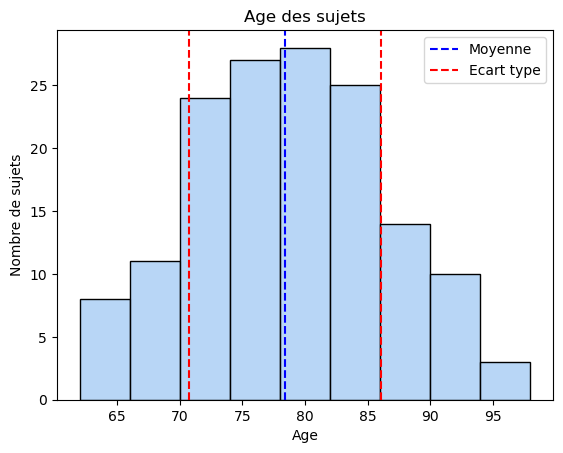

In [197]:
sns.histplot(data=data_u, x='age')

plt.axvline(age_mean, color='blue', linestyle='--', label='Moyenne')
plt.axvline(age_mean - age_std, color='red', linestyle='--', label='Ecart type')
plt.axvline(age_mean + age_std, color='red', linestyle='--')

plt.xlabel('Age')
plt.ylabel('Nombre de sujets')
plt.title('Age des sujets')
plt.legend()
plt.show()

**Observations** :
- L'âge des 150 sujets varie entre 62 et 98 ans
- La moyenne des âge est de 78 ans
- L'écart type est de 7.6
- La distribution des âges semble approximativement normale

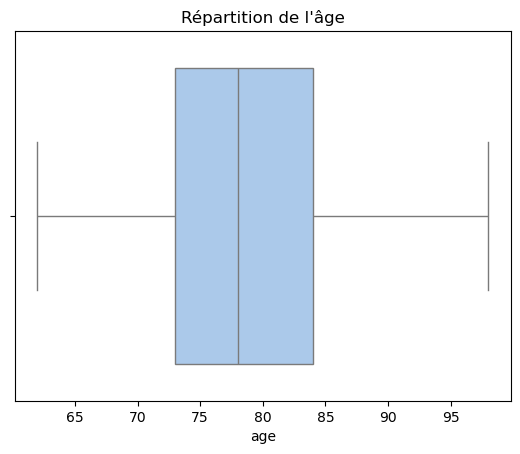

In [198]:
sns.boxplot(data=data_u, x='age')
plt.title("Répartition de l'âge")
plt.show()

Plusieurs informations nous parviennent de ce graphique boxplot (*boîte à moustaches*) sur l'âge des sujets de ce dataset :
- La médianne est à 78 ans, quasi égale à la moyenne, ce qui indique une forte symétrie dans les données, confirmée par la courbe en cloche vue sur l'histogramme précédent.
- Pas de valeurs abérrentes (*des points seraient apparus au dehors des moustaches*)

Afin d'illustrer la répartition par tranches d'âge, nous allons créer une nouvelle colonne classant l'âge du sujet selon des plages de valeurs déterminées.

Nous commençons par créer la fonction nous permettant de générer automatiquement le nom de nos classes.

In [199]:
def age_range(age : int) -> str:
    """ Fonction renvoyant le nom de la classe d'âge selon 
    la valeur du paramètre 'age' """
    if 60 <= age <= 65:
        return '60-65'
    elif 66 <= age <= 70:
        return '66-70'
    elif 71 <= age <= 80:
        return '71-80'
    elif 81 <= age <= 90:
        return '81-90'
    else:
        return '+90'

In [200]:
# Récupération de l'index de la colonne 'age'
age_index = data_u.columns.get_loc('age')

# Création de la nouvelle colonne
data_u.insert(age_index + 1, 'age_range', data_u['age'].apply(age_range))

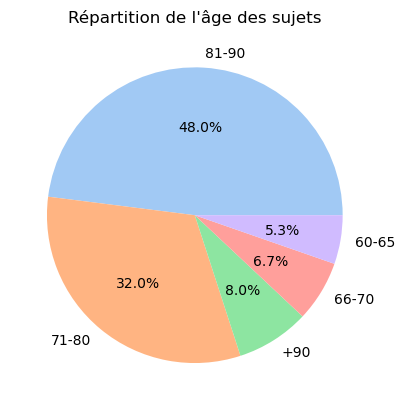

In [201]:
plt.pie(data_u['age_range'].value_counts(), labels=data_u['age_range'].unique(), autopct='%1.1f%%')
plt.title("Répartition de l'âge des sujets")
plt.show()

Observations :
- Les 81-90 ans représentent quasiment la moitié des sujets avec une représentation de 48%
- Vient ensuite les 71-80 ans avec 32%
- Les 71-90 ans représentent donc à eux seuls 80% des sujets
- Les 60-65 et les 66-70 représent à eux deux 12% des sujets avec respectivement 5.3% et 6.7%
- Les +90 ans représentent quant à eux 8% des sujets

### Groupe

La colonne `group` du dataframe contient 3 classes différentes :
- Demented : sujets atteints de démence
- Nondemented : sujets non atteints de démence
- Converted : sujets ayant developpé une démence au cours de leur suivi

Voyons leur répartition :

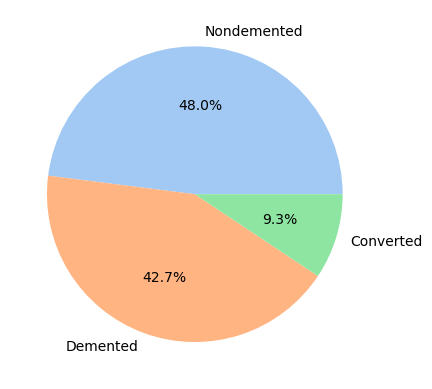

In [202]:
#sns.countplot(x='Group', data=data_u, order=data_u['Group'].value_counts().index)
plt.pie(data_u['group'].value_counts(), labels=data_u['group'].unique(), autopct='%1.1f%%')
plt.show()

Interprétation :
- La classe des sujets non déments (`Nondemented`) est la plus représentée, avec 48%.
- Mais si on prend en considération la somme des classes `Demented` et `Converted` représentées respectivement à 42.7% et 9.3%, celle-ci atteint 52%.
- Nous pouvons ainsi dire que plus de la moitié des sujets présents dans ce dataset ont été diagnostiqué d'une démence à leur premier exemen, ou l'ont été été durant leur suivi

### Genre

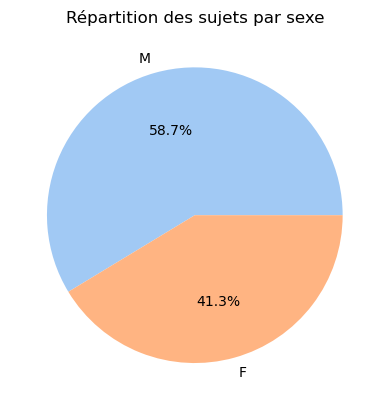

In [203]:
plt.pie(data_u['genre'].value_counts(), labels=data_u['genre'].unique(), autopct='%1.1f%%')
plt.title("Répartition des sujets par sexe")
plt.show()

Les sujet de ce dataset sont composés à majorité d'hommes avec 58.7%, contre 41.3% de femmes.

#### Niveau de démence par sexe

Nous allons tenter d'illustrer la répartition des différentes classes de démence en fonction du sexe du sujet. Pour cela nous allons commencer par créer deux dataframe, un pour chaque sexe.

In [204]:
male = data_u.loc[data_u['genre'] == 'M'] # df masculin
female = data_u.loc[data_u['genre'] == 'F'] # df féminin

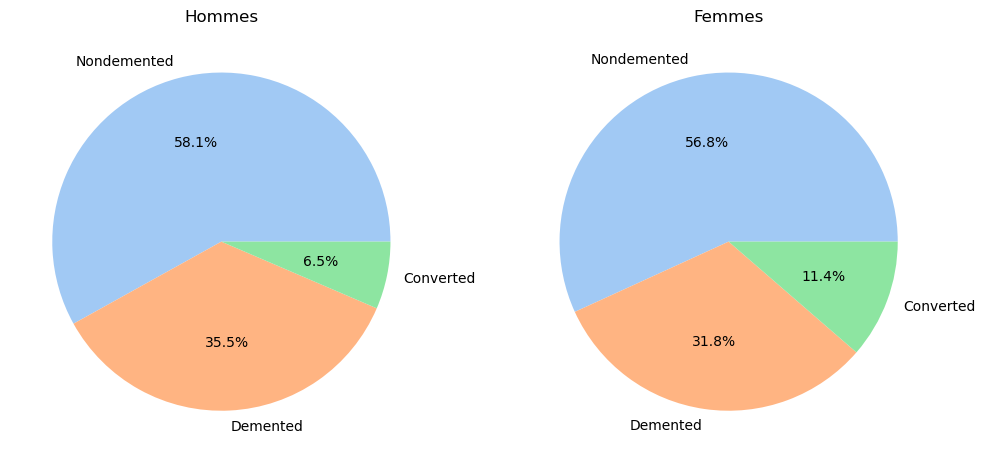

In [205]:
# Création d'une figure avec 1 ligne et 2 colonnes
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].pie(male['group'].value_counts(), labels=male['group'].unique(), autopct='%1.1f%%')
ax[0].set_title('Hommes')

ax[1].pie(female['group'].value_counts(), labels=female['group'].unique(), autopct='%1.1f%%')
ax[1].set_title('Femmes')

plt.show()

La répartition des niveaux de démence ne semble presque pas différer entre les hommes et les femmes, mis à part pour la classe converted dans laquelle les femmes semblent davantage représentées avec 11.4%, contre seulement 6.5% chez les hommes.

#### Scores cognitifs par sexe

In [206]:
# Récupération des moyennes MMSE pour chaque sexe
male_mmse_mean = male['MMSE'].mean()
female_mmse_mean = female['MMSE'].mean()

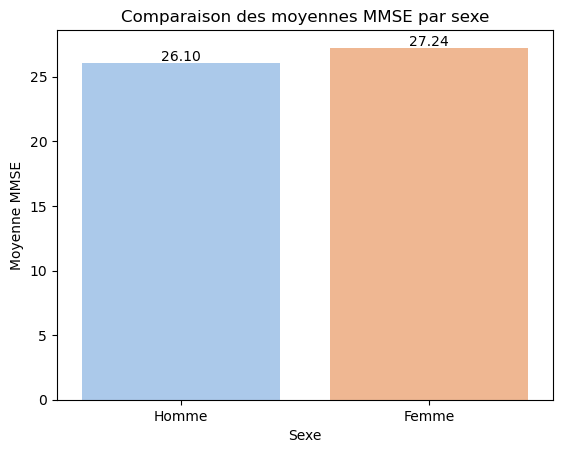

In [207]:
# Création d'un dataframe
df_mean = {'Sexe': ['Homme', 'Femme'], 'MMSE': [male_mmse_mean, female_mmse_mean]}
df_mean = pd.DataFrame(df_mean)

# Création du graphique à barres
ax = sns.barplot(x='Sexe', y='MMSE', data=df_mean, hue='Sexe')

# Affichage des valeurs sur les barres
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 4), 
                   textcoords = 'offset points')

plt.title('Comparaison des moyennes MMSE par sexe')
plt.ylabel('Moyenne MMSE')

plt.show()

Il ne semble pas y avoir de différence significative dans les moyennes du score MMSE entre les hommes et les femmes, avec respectivement 26.10 et 27.24 corréspondant à des niveaux d'atteinte nuls.

### Score MMSE

In [208]:
mmse_mean = data_u['MMSE'].mean()
mmse_std = data_u['MMSE'].std()

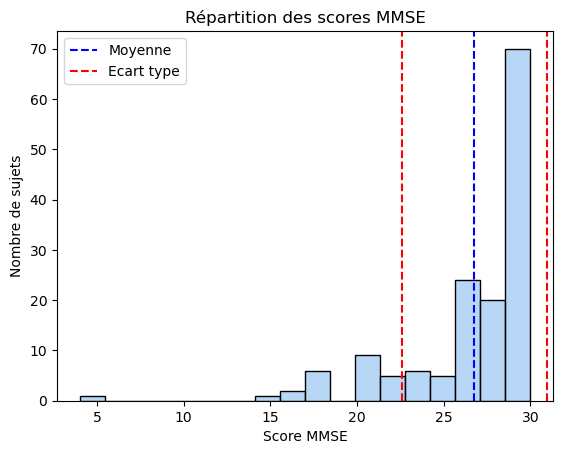

In [209]:
sns.histplot(data=data_u, x='MMSE')

plt.axvline(mmse_mean, color='blue', linestyle='--', label='Moyenne')
plt.axvline(mmse_mean - mmse_std, color='red', linestyle='--', label='Ecart type')
plt.axvline(mmse_mean + mmse_std, color='red', linestyle='--')

plt.xlabel('Score MMSE')
plt.ylabel('Nombre de sujets')
plt.title('Répartition des scores MMSE')
plt.legend()
plt.show()

### Corrélations

La fonction `corr()` du module Pandas permet d'afficher les valeurs de corrélation entre les différentes variables numériques d'un dataframe. 

Pour cela nous allons créer un dataframe nommé `df_num` qui ne sera composé que de colonnes numériques de type `int` ou `flaot`

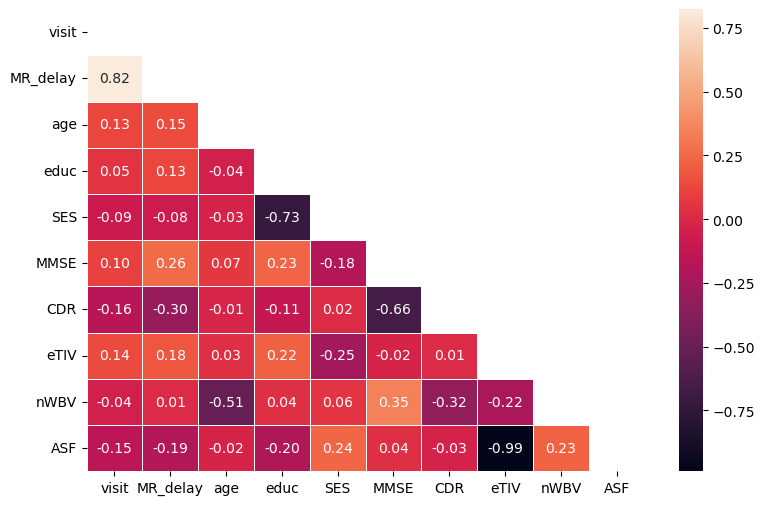

In [210]:
df_num = data_u.select_dtypes(include=['int', 'float']).corr()
plt.figure(figsize=(9, 6))
sns.heatmap(df_num, annot=True, fmt='.2f', linewidths=0.5, cmap='rocket', mask=np.triu(df_num))
plt.show()

#### Mesure de la corrélation entre `age` et `nWBV`

Nous allons ici nous intéresser plus particulièrement aux liens de corrélation entre l'age des sujets et le volume de leur cerveau (plus exactemement, le raport entre le volume du cerveau et celui de la boite crânienne), représenté ici par la variable `nWBV`.

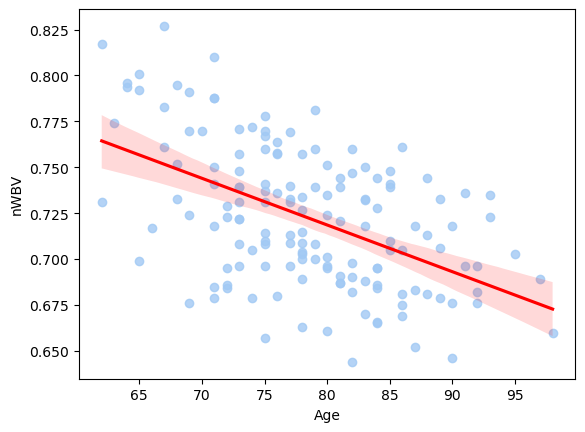

In [211]:
sns.regplot(x='age', y='nWBV', data=data_u, line_kws={'color' : 'red'})
plt.xlabel("Age")
plt.ylabel("nWBV")
plt.show()

Le graphique en nuage de points, où chaque point représente un sujet, nous montre que plus le patient est âgé et plus le volume de son cerveau a tendance à diminuer. Cela est clairement souligné par la droite de régression en rouge.

> **Mesure de la significativité de la corrélation**
>
>Pour déterminer si une corrélation entre deux séries de variables est **significative**, une méthode consiste à vérifier la probabilité qu'une telle distribution de valeurs soit dû au simple hasard, cette valeur de probabilité est appelée la **valeur p**. La fonction `pearsonr` de la bibliothèque `scipy.stats` permet de l'obtenir.
>
>Par convention, il est admis qu'une valeur p **inférieure** à **0.05** signifie que la corrélation statistique entre les deux variables est significative, qu'elle n'a donc que très peu de chance d'être dû au simple hasard. On dit que l'**hypothèse nulle** est rejetée, ou fausse.
>
>Au contraire, une valeur p supérieure à 0.05 signifie qu'il n'existe pas de relation significative entre les deux variables, que des valeurs distribuées aléatoirement auraient pu approcher du même résultat. On dit que l'hypothèse nulle est vérifiée ou vraie.

In [212]:
# Calcul de la corrélation et de la valeur p
correl, p_value = pearsonr(data_u['age'], data_u['nWBV'])
correl, p_value

(-0.5089423473748238, 2.93130700508026e-11)

- La corrélation entres les variables `age` et `nWBV` est d'environ -0.50
- La corrélation négative indique que les deux variables sont inversement proportionnelles
- La valeur p est d'environ 2.9313e-11 ce qui est nettement inférieur au seuil des 0.05. Cela signifie que les deux variables ont une corrélation hautement significative (le hasard ne saurait aisément reproduire une pareille distribution de valeurs)

#### Mesure de la corrélation entre `nWBV` et `MMSE`

Voyons de plus près la corrélation entre la variable `nWBV` et `MMSE`, autrement dit entre le volume du cerveau et le score d'évaluation cognitif MMSE.

> **Rappel** : Plus le score MMSE (*Mini Mental State Examination*) est élevé plus l'atteinte du sujet est nulle :
> - += 27 = Atteinte nulle
> - 21-26 = Atteinte légère
> - 11-20 = Atteinte modérée
> - <=10 = Atteinte sévère

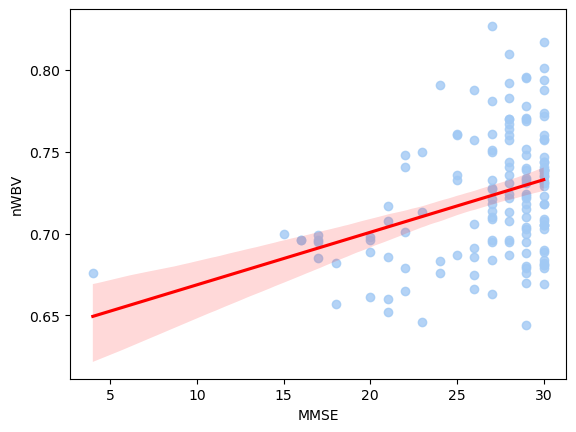

In [213]:
sns.regplot(x='MMSE', y='nWBV', data=data_u, line_kws={'color' : 'red'})
plt.xlabel("MMSE")
plt.ylabel("nWBV")
plt.grid(False)
plt.show()

In [214]:
# Suppression des données manquantes sur la colonne MMSE
df_nonan = data_u.dropna(subset=['MMSE'])

# Calcul du coéfficient de corrélation et de la valeur p
corr, p_value = pearsonr(df_nonan['MMSE'], df_nonan['nWBV'])
corr, p_value

(0.34884227560047654, 1.3002334006217158e-05)

In [215]:
df_nonan['MMSE'].std()

4.172608979913681

**Interprétation des résultats**
- La droite de régression nous montre qu'il existe une tendance soulignant une corrélation positive entre le volume du cerveau et le score MMSE. Autrement dit plus le volume du cerveau est gros, plus le score d'évaluation est élevé.
- Cependant, on remarque une forte dispersion des points autour de la ligne de régression, indiquant qu'il existe une assez forte variabilité individuelle : un certain nombre de patients ne suit pas cette tendance
- Nous pouvons voir qu'un bon nombre de sujets possède un score d'évaluation cognitif élevé malgré un volume de cerveau réduit, ce qui laisse penser que **la baisse du volume cérébral n'est pas le seul facteur du faible score cognitif**.

#### Mesure de la corrélation entre `educ` et `MMSE`

Analyse des corrélations entre le niveau d'étude des sujets et leur score d'évaluation cognitif MMSE et CDR.

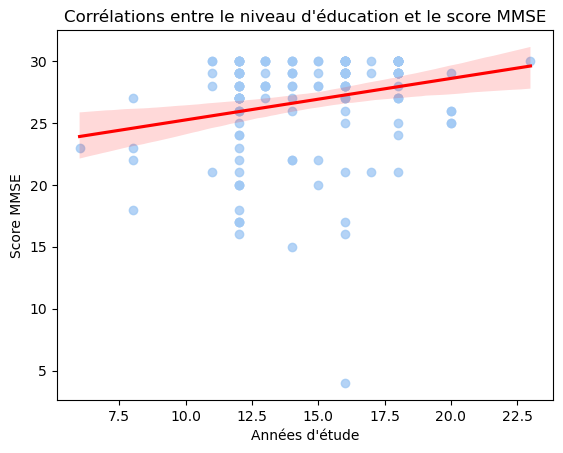

In [216]:
sns.regplot(x='educ', y='MMSE', data=data_u, line_kws={'color' : 'red'})
plt.xlabel("Années d'étude")
plt.ylabel("Score MMSE")
plt.title("Corrélations entre le niveau d'éducation et le score MMSE")
plt.show()

In [217]:
corr, p_value = pearsonr(df_nonan['educ'], df_nonan['MMSE'])
corr, p_value

(0.23092823575376492, 0.004604111141733722)

Avec un coéfficient de corrélation et une valeur p à 0.004 il semble y avoir une corrélation statistique positive assez significative entre le score cognitif MMSE du sujet et son niveau d'étude.

In [218]:
# Corrélations avec le score CDR
corr, p_value = pearsonr(df_nonan['educ'], df_nonan['CDR'])
corr, p_value

(-0.10160675599969901, 0.2175694238666137)

Le coéfficient de corrélation entre le niveau d'éducation et le score CDR est en revanche bien moins concluant, de même que la valeur p